# Project 2 - Event Studies

Bowen Chen

January 26, 2018

## Executive Summary

In this event study project, the performance of the stock during 40 closest days near a dividend event is examined. Since the stock price often drop on the dividend date, there is a common misunderstanding of change in stock's market value. From the analysis, it is clear that **stock returns recovers to its normal level** after recording a **-0.7%** drop on dividend ex-date **in a really short period of time**. It is also an evidence of the stationarity of stock's market value - stock's market value is determined by the outlook of investors of the market that will not be affected by events like dividend payouts.

## Key Questions to Answer

*From the year 2010 to 2016,*


* How stocks perform in terms of excess rates of return when they are actually paying a dividend?


* Is there a clear change in stock's market value if the stock is paying a dividend?

## Computations

R setup, import all the necessary packages

In [14]:
library(data.table)
library(reshape2)
library(magrittr)
library(lubridate)
library(dplyr)
library(ggplot2)
options(repr.plot.width= 6, repr.plot.height=4, warn = -1)

**Import Data**

Import both stock returns and S&P500. The events data is downloaded from the CRSP database in the Whorton Research Data Services  under "Stock/Events" section, which is being stored in *StockReturns*. *StockReturns* consists of 4 columns, 
* PERMNO - The unique stock identifier
* date - The date, in daily frequency
* RCRDDT - The dividend payout date 
* RETX - The stock's daily return

The S&P 500 data is download CRSP database under "Index / S&P 500 Indexes", which is being stored in *SP500*. *SP500* consists of 2 columns,

* date - The date, in daily frequency
* vwretd - S&P 500's daily return, with the dividend distributin adjusted

In [2]:
StockReturns = fread("data//events.csv")
SP500 = fread("data//SP500.csv")

Read 12116406 rows and 4 (of 4) columns from 0.311 GB file in 00:00:05


**Event Days**

The *StockReturns* is a giant datatable that consists of daily return data of over 10,000 stocks from 2010 to 2016. Since the dividend event does not happen every day, the column that contains dividend payout date is very sparse. For simplicity purposes, the event date (ex-date) is chosen to be the day that dividend payout date is recorded. All of the events are stored in a separate data table named *eventdays*

In [3]:
eventdays = StockReturns[RCRDDT!='',c('PERMNO','date', 'RCRDDT')]
eventdays[,date := as.Date(date, format = '%m/%d/%Y')]
setkey(eventdays, PERMNO)

**Filter non-event stocks**

A few exploratory data analysis showed that not all of the stock has a dividend payout during the analysis period. These stocks are removed to make the dataset smaller. After the filtering, there are around 7500 stocks left

In [4]:
hasEvent = unique(eventdays$PERMNO)

In [5]:
StockReturns[,  `:=` (date = as.Date(date, format = '%m/%d/%Y'),
                      RETX = as.numeric(RETX))]

StockReturns = StockReturns[PERMNO %in% hasEvent,]

**Find all excess returns** 

The S&P 500 data table is joined to the stock return table, the excess return of each stock over S&P is found. Since the dataset is too large, setting the key of the *StockExcessReturns* is very important for performance reasons

In [6]:
SP500[,caldt := ymd(caldt)]

In [7]:
StockExcessReturns = merge(StockReturns, SP500, 
                            all.x = T, by.x = 'date', by.y = 'caldt', na.rm = TRUE)

StockExcessReturns[, `:=`(excess_return = RETX - vwretd)]
setkey(StockExcessReturns, PERMNO)

**Generating Event Windows**

Generating the event windows is the toughest part of this analysis. The methodology of event study is to line up all stock excess returns on the event dates, find the -20 to 20 days of stock returns and calculate the mean across all stock-days. There are 3 main hurdles in performing such a task,

1. There are overlapping periods when the stock paying dividends too frequently (less than 40 days between two dividend payout days). After careful consideration, the overlapping period will not be a issue since each event is treated differently

2. The stock pays out dividends before 20 days has passed in the dataset. This will lead to missing data in the data table that hosts all the events, therefore is removed.

3. Different stock dividend payout should be able distinguish themselves.

To distinguish events for different stocks, the *StockExcessReturns*, *eventdays* data table are split into groups by its unique identifier - PERMNO

In [8]:
StockGroups = split(StockExcessReturns, StockExcessReturns$PERMNO)
eventGroups = split(eventdays, eventdays$PERMNO)

**Generate event window returns for a single stock**

To generate event window for all stock, we will need to start from a single stock and generalize that technique. For every single stock group, 

1. identify the event date, and choose the 20 days before and 20 days after the event day
2. extract the excess returns of that 41 days and save them in a 2D array

In [9]:
findEventReturns <- function(x, y)
{
    # save all ex_dates
    events = y[,date]
    ex_date = which(x[,date] %in% events)
    
    # build event windows for every 41 days
    event_window = as.vector(mapply(seq, ex_date - 20, ex_date + 20))
    event_windows = split(event_window, ceiling(seq_along(event_window)/41))
    
    # remove ex-days without a full event window
    event_windows =  event_windows[sapply(event_windows, function(i) (i[1] > 0 & i[41] < 1762))]
    eventset = t(sapply(event_windows, function (i) x[i,excess_return]))   
        
    return (eventset)
}

**Generate the event window for all stocks**

Now the function could be applied to all of the StockGroups, return the result as a list of that contains all the dividend events. This opreation is similar to cross-applying two lists that have corresponding stock identifiers

In [10]:
eventStudyList = mapply(findEventReturns, x = StockGroups, y = eventGroups)

**Collect the data into one event study table**

The event window is stored in a giant list. To find the mean of each event study day, the list of event study need to be converted to a data table. Since some of the stocks have been unlisted from NYSE after a certain period, the missing return data is treated as 0

In [11]:
eventStudyList = lapply(eventStudyList, as.data.table)
eventStudytable = rbindlist(eventStudyList)
eventStudytable[is.na(eventStudytable)] = 0 

** Mean return of each day** 

Find mean of the every day of event study window

In [12]:
eventStudymean = as.data.table(cbind( days = seq(-20,20),
                                      excess_return = apply(eventStudytable, 2, mean)))

**Visualization**

To have a better view of how stock performs during a dividend payout, plot the return of the event study window of 41 days in a line plot

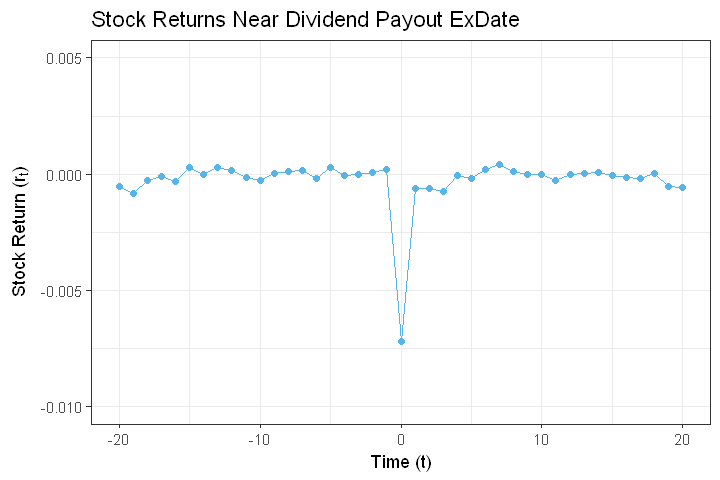

In [13]:
# Plot Event Study Return
ggplot(data=eventStudymean, aes(x=days, y= excess_return, group=1)) +
  theme_bw()+
  geom_line(color="#56B4E9") +
  geom_point(color="#56B4E9")+
  ylim(-0.01, 0.005) +
  labs(title = "Stock Returns Near Dividend Payout ExDate",
  x = "Time (t)", 
  y = expression(paste("Stock Return (",r[t], ")")),
  parse = TRUE)

Now it is time to answer the key question,

*How stocks perform in terms of excess rates of return when they are actually paying a dividend?*

The stocks clearly has a sharpe drop in value on the ex-dividend date due to the anticipation of stock price change across all the investors. There are some moderate signs of stock price rising before the ex-date - possibly due to the buying activities of investors having positive outlooks for the dividend paying stock. After the dividend ex-date, the realtive low value of stock value could induce more buying activities for the stock, evident from the 4 days of stock having positive returns. Eventually the stock goes back to the level before the dividend is paid.

So, *Is there a clear change in stock's market value if the stock is paying a dividend?*

Clearly, the answer is no. The stock price will be temporary lower immediately after the dividend payout, but the market value of stock is determined by the outlook of investors of the market. If the stock price is low, the investors will keep buying it until the stock is back to its fair value